In [1]:
import os
import copy
import salem
from oggm import cfg, utils, workflow, graphics, tasks
from oggm.core.flowline import equilibrium_stop_criterion, FileModel
import oggm
import plot_gcm
from functools import partial
from moepy import lowess
import random
import numpy as np
import warnings

import xarray as xr
import pandas as pd
import geopandas as gpd
import plot_gcm
import importlib
import dask
from scipy import optimize
from dask.diagnostics import ProgressBar

from cycler import cycler
import matplotlib as mpl
from matplotlib import colors
import matplotlib.patches as mpatches
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

warnings.filterwarnings(action='ignore', message='All-NaN slice encountered')
dask.config.set({"array.slicing.split_large_chunks": False})

# create cmap
color_list=[colors.to_rgb('#'+c) for c in ["001219","003946","005f73","0a9396","4fb3aa","94d2bd","e9d8a6","ecba53","ee9b00","dc8101","bb3e03","8d210c","5e0314"]]
gcm_cmap = cmap = mpl.colors.ListedColormap(color_list)
custom_cycler = cycler(color=gcm_cmap.colors)

In [7]:
mpl.rcParams['axes.linewidth'] = 3
mpl.rcParams['xtick.major.width'] = 3
mpl.rcParams['ytick.major.width'] = 3
mpl.rcParams['font.size'] =30
mpl.rcParams['font.weight'] = 'medium'
mpl.rcParams['axes.labelweight'] = 'medium'
mpl.rcParams['legend.fontsize'] = 20 #30
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['xtick.major.pad']='8'
mpl.rcParams['ytick.major.pad']='8'
mpl.rcParams["figure.figsize"] = (15,10)

In [3]:
READING_DIR='out/run_CMIP6_geod'

# read geodetic output
with ProgressBar():
    p = os.path.join(READING_DIR,'11_equilibrium.nc')
    all_ds = xr.open_mfdataset(p, parallel=True)
    
all_ds = all_ds.assign_coords({"region": all_ds.rgi_id.str[6:8]}).equilibrium

order=['CanESM5', 'NorESM2-MM', 'FGOALS-f3-L','BCC-CSM2-MR', 'MRI-ESM2-0','MPI-ESM1-2-HR','ACCESS-CM2', 'EC-Earth3', 'MIROC6','CESM2','GISS-E2-2-H','IPSL-CM6A-LR-INCA','E3SM-1-1','CRU']
ex_2_hot=['FGOALS-f3-L', 'BCC-CSM2-MR', 'MRI-ESM2-0', 'MPI-ESM1-2-HR', 'ACCESS-CM2', 'MIROC6', 'CESM2', 'GISS-E2-2-H','CRU']
all_ds = all_ds.sel(gcm=order)


[########################################] | 100% Completed | 324.21 ms


In [4]:
# remove nan values 
ds = xr.concat([all_ds.sel(gcm=gcm).dropna(dim='year',how='all').dropna(dim='rgi_id',how='any') for gcm in all_ds.gcm.values],dim='gcm')
ds = ds.assign_coords({"region": ds.rgi_id.str[6:8]})

In [5]:
ds_sum = ds.groupby('region').sum(min_count=1)

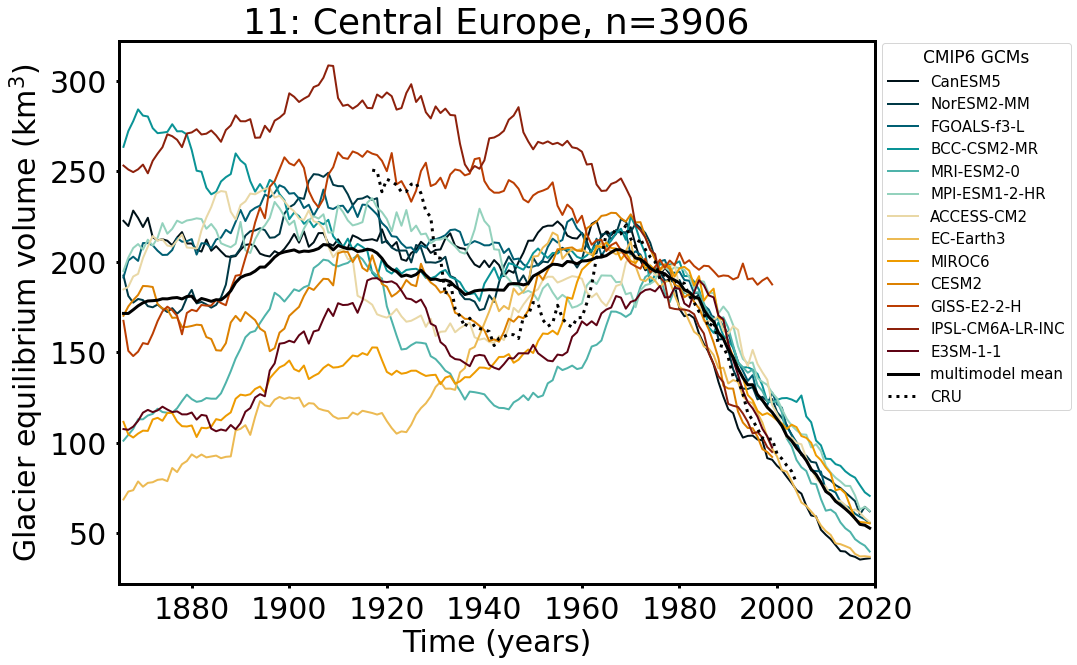

In [8]:
importlib.reload(plot_gcm)

fig = plt.figure(figsize=(15,10))
fig.patch.set_facecolor('white')
grid = plt.GridSpec(1,1,left=0.1,right=0.8)
ax = fig.add_subplot(grid[0])

plot_gcm.plot_volume_km3(ds_sum,'11', n=len(all_ds.rgi_id.values), ax=ax)
ax.set_title('11: Central Europe, n='+str(len(ds.rgi_id)));
#plt.savefig(os.path.join('out','run_CMIP6_geod','plots','global','global_volume_km3.png'),dpi=300);

In [9]:
def convert_km3_to_sle(ds): 
    # convert volume (km^3) to mass (Gt)
    mass = ds*0.9167
    # convert mass (Gt) to sle
    sle = mass*(1 / 361.8)
    return sle    

In [10]:
ds_dt = ds_sum-ds_sum.sel(year=1998)
sle_dt = convert_km3_to_sle(-ds_dt)

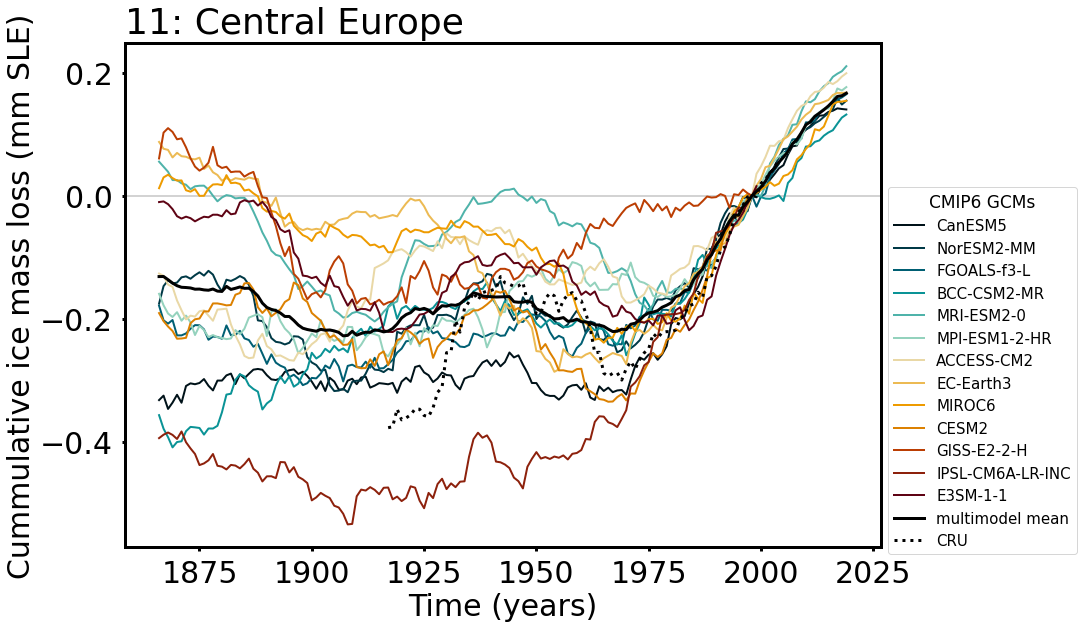

In [11]:
importlib.reload(plot_gcm)

fig = plt.figure(figsize=(15,10))
fig.patch.set_facecolor('white')
grid = plt.GridSpec(1,1,left=0.1,right=0.8, top=0.825)
ax = fig.add_subplot(grid[0])

plot_gcm.plot_mass_loss_sle(sle_dt, '11', n=len(ds.rgi_id), ax=ax, add_legend=True,lw=2);

## Preindustrial temperatures


### Global mean temperature of each gcm
We have calculated the global mean temperature anomalies relative to preindustrial conditions [here](./GMT.ipynb) and only need to load the results:

In [12]:
import xarray as xr
gmt =  xr.open_dataset('cmip6_select/GMT_anomly.nc').tas
gmt

<xarray.DataArray 'tas' (gcm: 14, time: 185)>
[2590 values with dtype=float64]
Coordinates:
  * time     (time) int64 1850 1851 1852 1853 1854 ... 2030 2031 2032 2033 2034
  * gcm      (gcm) object 'CanESM5' 'NorESM2-MM' ... 'E3SM-1-1' 'HadCRUT5'
Attributes:
    description:     Global temperature Anomalies (bias corrected)\n relative...
    units:          °C
    creation_date:  2023-01-06 09:54:00

We need to calcualte the 30-year rolling mean: 

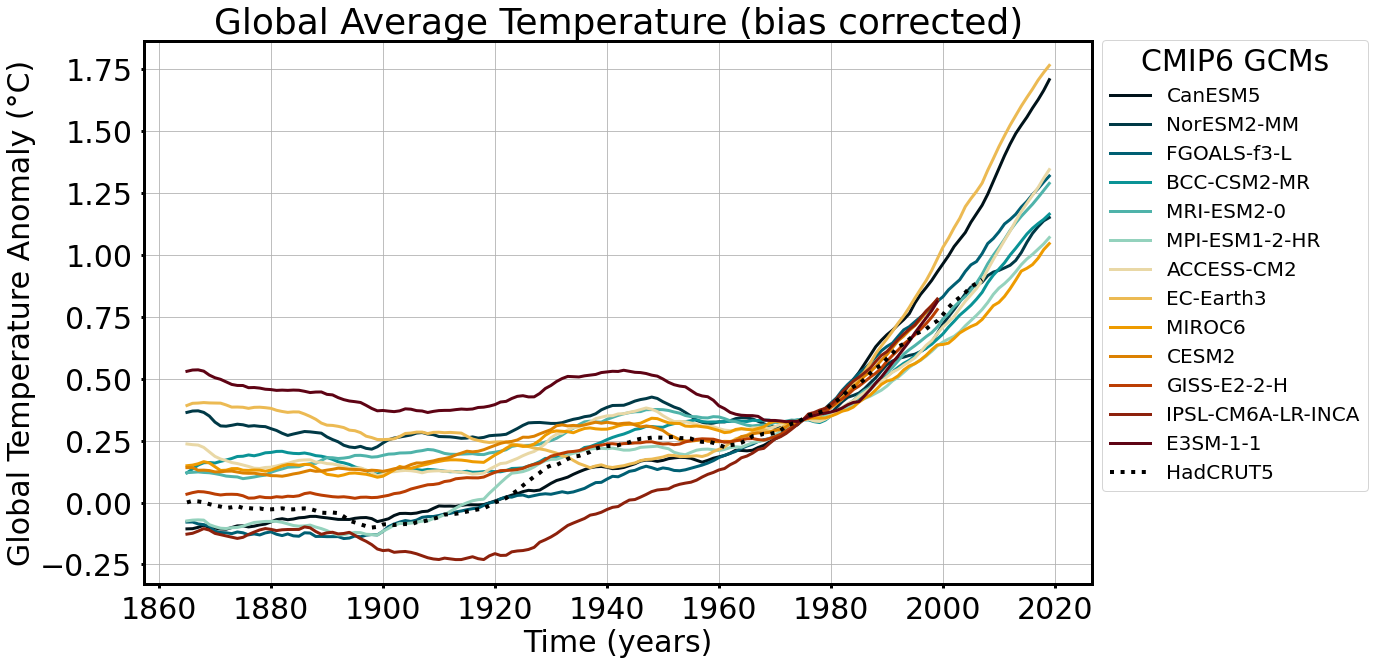

In [13]:
plt.figure(figsize=(17,10))
ax=plt.gca()

ax.set_prop_cycle(plot_gcm.create_color_cycler(3, n=len(order)-1))
gmt.rolling(time=31,center=True).mean().plot(hue='gcm')   
ax.set_title('')
ax.set_xlabel('Time (years)')
ax.set_ylabel('Global Temperature Anomaly (°C)')
ax.set_title('Global Average Temperature (bias corrected)') 
ax.get_legend().set_bbox_to_anchor((1, 1.02))
ax.get_legend().set_title("CMIP6 GCMs")
plt.grid()

### Merge GMT data and equlibrium data together

In [14]:
df = gmt.rolling(time=31,center=True).mean().dropna(dim='time', how='all').to_pandas()
df = df.iloc[:-1,1:].T;

df_eq = ds_sum.sel(region='11').to_pandas().drop('CRU').T

def merge_df(gcm):
    d = pd.concat([df.loc[:,gcm], df_eq.loc[:,gcm]],keys=['GMT','equilibrium'],names=gcm,axis=1).to_xarray()
    d = d.assign(year=d.index)
    d = d.assign_coords(gcm=gcm)
    d = d.set_index(index='GMT').rename({'index':'GMT'})
    
    d = d.dropna(dim='GMT')
    return d
gcm_ds = xr.concat([merge_df(gcm) for gcm in df.columns], dim='gcm')

In [15]:
gcm_ds

<xarray.Dataset>
Dimensions:      (GMT: 1919, gcm: 13)
Coordinates:
  * GMT          (GMT) float64 -0.2303 -0.2302 -0.2302 ... 1.708 1.737 1.765
  * gcm          (gcm) <U17 'CanESM5' 'NorESM2-MM' ... 'E3SM-1-1'
Data variables:
    equilibrium  (gcm, GMT) float64 nan nan nan nan nan ... nan nan nan nan nan
    year         (gcm, GMT) float64 nan nan nan nan nan ... nan nan nan nan nan

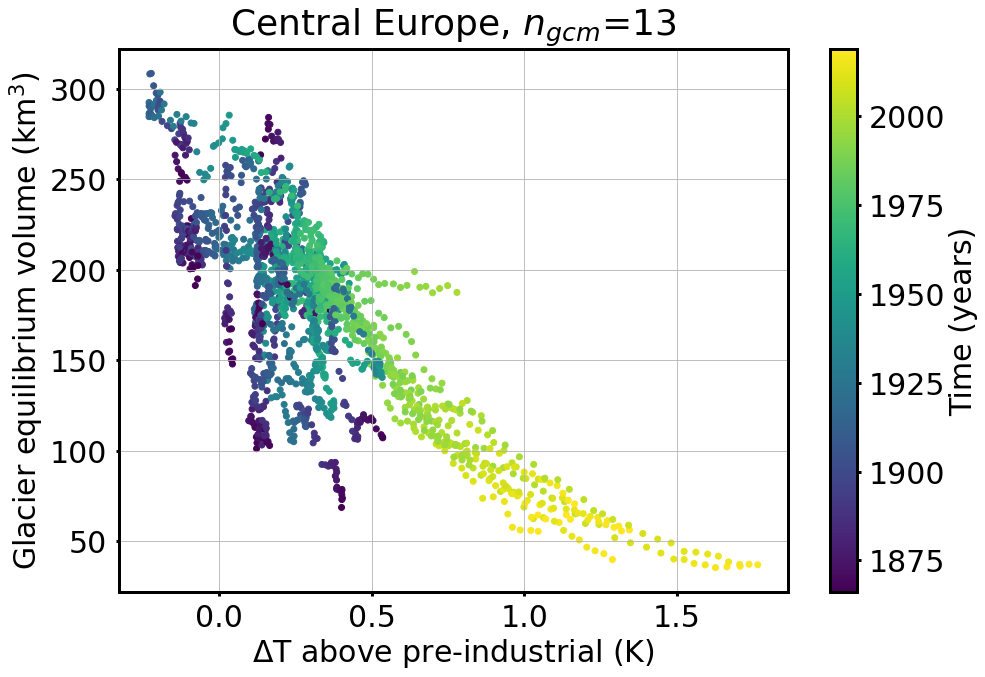

In [16]:
ax=plt.gca()
norm = mpl.colors.Normalize(vmin=1866, vmax=2019)
for gcm in gcm_ds.gcm:
    df_gcm_r = gcm_ds.sel(gcm=gcm).to_pandas().reset_index()
    d = ax.scatter(df_gcm_r.GMT, df_gcm_r.equilibrium, c=df_gcm_r.year, norm=norm)
cb = plt.colorbar(d, label='Time (years)',ticks=[1875,1900,1925,1950,1975,2000])
ax.set_ylabel(r'Glacier equilibrium volume (km$^3$)');
ax.set_xlabel(r'$\Delta$T above pre-industrial (K)');
ax.grid()
ax.set_title(r'Central Europe, $n_{gcm}$=13');
plt.savefig(os.path.join('out/run_CMIP6_geod/plots/regional/Alps','scatter_GMT.png'),dpi=300)

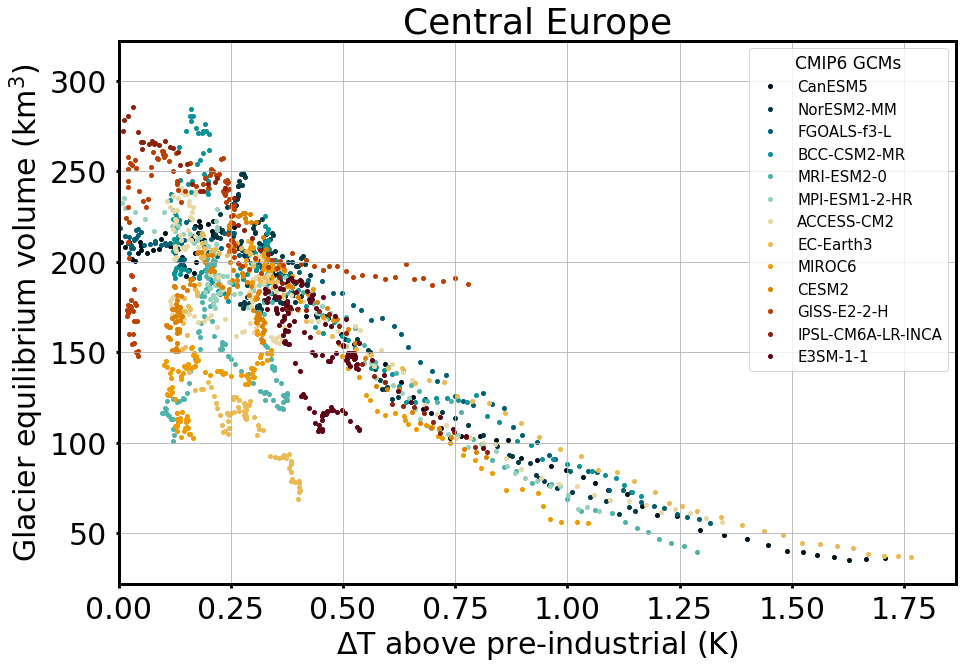

In [17]:
ax = plt.gca()
ax.set_prop_cycle(plot_gcm.create_color_cycler(lw=3,n=13))

# draw points 
ax.set_prop_cycle(plot_gcm.create_color_cycler(lw=3,n=13))
gcm_ds.equilibrium.to_pandas().T.plot(lw=0, marker='o',ax=ax,markersize=4,legend=False,zorder=1,alpha=1)

leg = plt.legend(fontsize=15)
leg.set_title('CMIP6 GCMs',prop={'size':17})

ax.set_ylabel(r'Glacier equilibrium volume (km$^3$)');
ax.set_xlabel(r'$\Delta$T above pre-industrial (K)');
ax.grid()
ax.set_title(r'Central Europe')
ax.set_xlim(0,None)
plt.savefig(os.path.join('out/run_CMIP6_geod/plots/regional/Alps','equilibrium_GMT_scatter.png'),dpi=300)

#### Get $\Delta$ GMT from CO$_2$ emissions

In [18]:
co2_gmt = pd.read_csv('T_diff_CO2.csv').set_index('Year').sum(axis=1)
co2_gmt

Year
1850    0.000017
1851    0.000073
1852    0.000158
1853    0.000257
1854    0.000367
          ...   
2016    0.691261
2017    0.706073
2018    0.720968
2019    0.735997
2020    0.748890
Length: 171, dtype: float64

### Find representative of this dataset 
The data is quite noisy and spaced irregular on the x-axis, which makes some troubles when calculating the median. We need to find a method that smoothes out the noise. Following approaches didn't work that well: 

- rolling median (too large window necessary)
- coarsen median (either too noisy or to edgy)
- piecewise median regression (to edgy)
- gaussian regression (only mean and std larger for higher $\Delta$GMT because of reduced number of datapoints)

#### Remove info about individual gcms  (treat all datapoints equally)
This might be helpfull for the regression

In [19]:
all_df = pd.DataFrame()
for gcm in gcm_ds.gcm:
    df_gcm_r = gcm_ds.sel(gcm=gcm).to_pandas().reset_index()
    all_df = pd.concat([all_df,df_gcm_r.dropna().drop('gcm',axis=1)],ignore_index=True)
all_df = all_df.sort_values(by='GMT')

#### LOWESS regression
This worked best :)

In [20]:
# calculates the quantiles (0.1,0.5,0.9) with LOWESS
df_quantiles = lowess.quantile_model(all_df.GMT.values, all_df.equilibrium.values,qs=[0.1,0.5,0.9],x_pred=np.linspace(-0.25,1.75,100),
                                     frac=0.7, num_fits=20)

100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.45it/s]


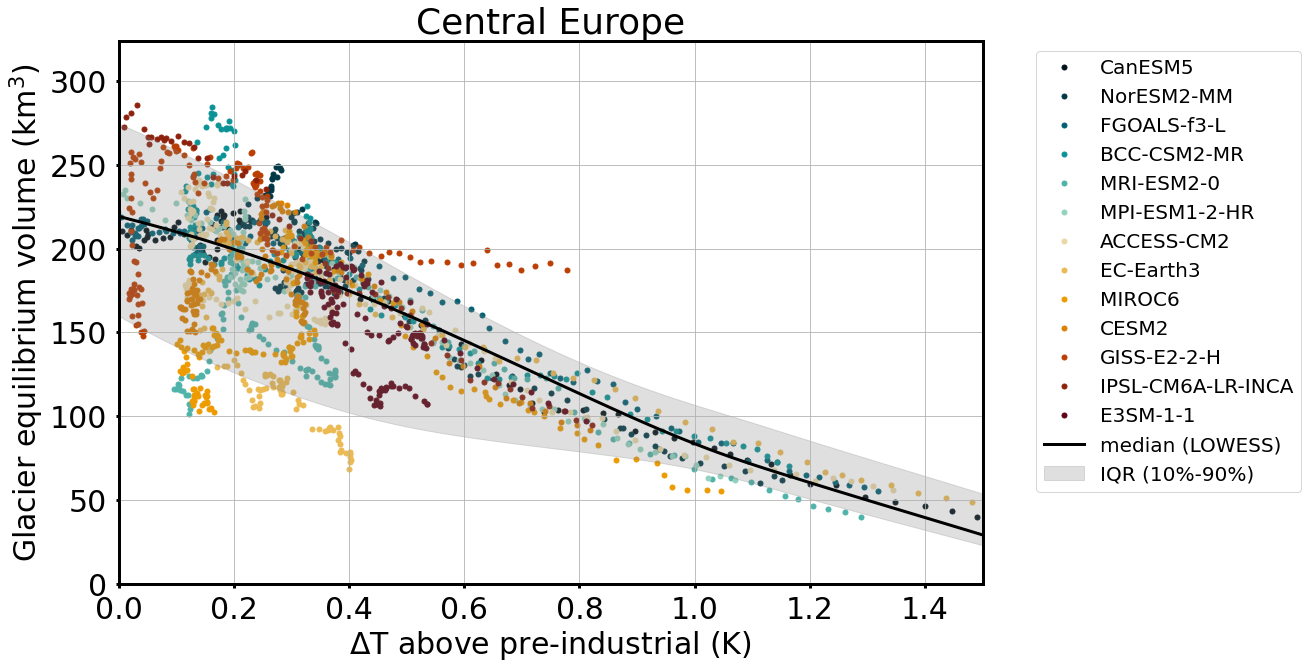

In [21]:
# plot the result
fig = plt.figure(figsize=(20,10))
fig.patch.set_facecolor('white')
grid = plt.GridSpec(1,1,left=0.1,right=0.7)
ax = fig.add_subplot(grid[0])

ax.set_prop_cycle(plot_gcm.create_color_cycler(lw=3,n=13))
gcm_ds.equilibrium.to_pandas().T.plot(lw=0,marker='o',ax=ax,markersize=5,legend=False,zorder=1,alpha=1)

# plot Lowess median
ax.plot(df_quantiles.index, df_quantiles[0.5], color='k', linestyle='-',lw=3, label='median (LOWESS)')

# quantile range
ax.fill_between(df_quantiles.index, df_quantiles[0.1], df_quantiles[0.9], color='grey', alpha=0.25, label='IQR (10%-90%)')

ax.legend(bbox_to_anchor=(1.05, 1))

ax.set_ylim(0)
ax.set_xlim(0,1.5)

ax.set_ylabel(r'Glacier equilibrium volume (km$^3$)');
ax.set_xlabel(r'$\Delta$T above pre-industrial (K)');
ax.grid()
ax.set_title('Central Europe')
plt.savefig(os.path.join('out/run_CMIP6_geod/plots/regional/Alps','equilibrium_GMT_lowess.png'),dpi=300)

### Methods working not that good
#### Gaussian regression

In [22]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, WhiteKernel

# x_in and y_in
X_train = all_df.GMT.values.reshape(-1, 1)
Y_train = all_df.equilibrium.values.reshape(-1, 1)

# x out
X = np.linspace(-0.25,1.75,100).reshape(-1,1)


rbf = 50.0**2 * RBF(length_scale=50.0)
noise_kernel = 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=50, noise_level_bounds=(1e-5, 1e5))
kernel= (rbf+noise_kernel)
gpr = GaussianProcessRegressor(kernel=kernel, alpha=100) #alpha=noise**2

# Reuse training data from previous 1D example
gpr.fit(X_train, Y_train)

# Compute posterior mean and covariance
mu_s, cov_s = gpr.predict(X, return_std=True)

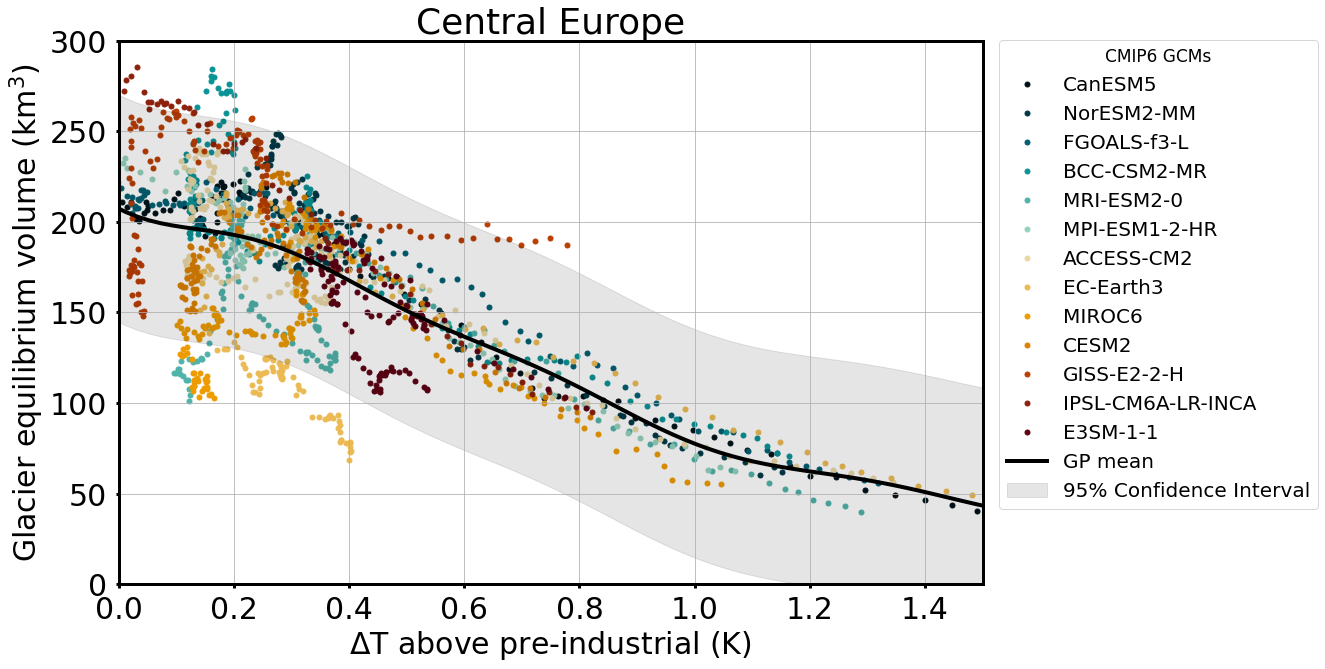

In [23]:
fig = plt.figure(figsize=(20,10))
fig.patch.set_facecolor('white')
grid = plt.GridSpec(1,1,left=0.1,right=0.7)
ax = fig.add_subplot(grid[0])

ax.set_prop_cycle(plot_gcm.create_color_cycler(lw=3,n=13))

# draw points 
ax.set_prop_cycle(plot_gcm.create_color_cycler(lw=3,n=13))
gcm_ds.equilibrium.to_pandas().T.plot(lw=0, marker='o',ax=ax,markersize=5,legend=False,zorder=1,alpha=1)

ax.plot(X,mu_s.ravel(),linestyle='-',color='k', label='GP mean')
ax.fill_between(X.ravel(),mu_s.ravel()-2*cov_s.ravel(),mu_s.ravel()+2*cov_s.ravel(),alpha=0.1,color='k', label=r'95% Confidence Interval')
leg = ax.legend(loc=1, bbox_to_anchor=(1.4,1.02))
leg.set_title('CMIP6 GCMs',prop={'size':17});

ax.set_xlim((0, 1.5))
ax.set_ylim((0,300))
ax.set_ylabel(r'Glacier equilibrium volume (km$^3$)');
ax.set_xlabel(r'$\Delta$T above pre-industrial (K)');
ax.grid()
ax.set_title('Central Europe')
plt.savefig(os.path.join('out/run_CMIP6_geod/plots/regional/Alps','equilibrium_GMT_GP.png'),dpi=300)

#### Piecewise Median-Regression

In [24]:
def segments_fit(X, Y, count, method, q=None):
    xmin = X.min()
    xmax = X.max()

    seg = np.full(count - 1, (xmax - xmin) / count) 

    px_init = np.r_[np.r_[xmin, seg].cumsum(), xmax]
    py_init = np.array([Y[np.abs(X - x) < (xmax - xmin) * 0.01].mean() for x in px_init])

    def func(p):
        seg = p[:count - 1]
        py = p[count - 1:]
        px = np.r_[np.r_[xmin, seg].cumsum(), xmax]
        return px, py

    def err(p):
        px, py = func(p)
        Y2 = np.interp(X, px, py)
        if method=='median':
            return np.median(np.abs(Y - Y2)) # --> median regression
        if method=='mean':
            return np.mean((Y - Y2)**2) # --> least-square regression
    
    r = optimize.minimize(err, x0=np.r_[seg, py_init], method='COBYLA')
    print(r.success)
    return func(r.x)

X = all_df.sort_values(by='GMT').GMT.values
Y = all_df.sort_values(by='GMT').equilibrium.values 

# piecewise linear regression with 10 brackpoints 
median_x, median_y = segments_fit(X, Y,10,method='median')

True


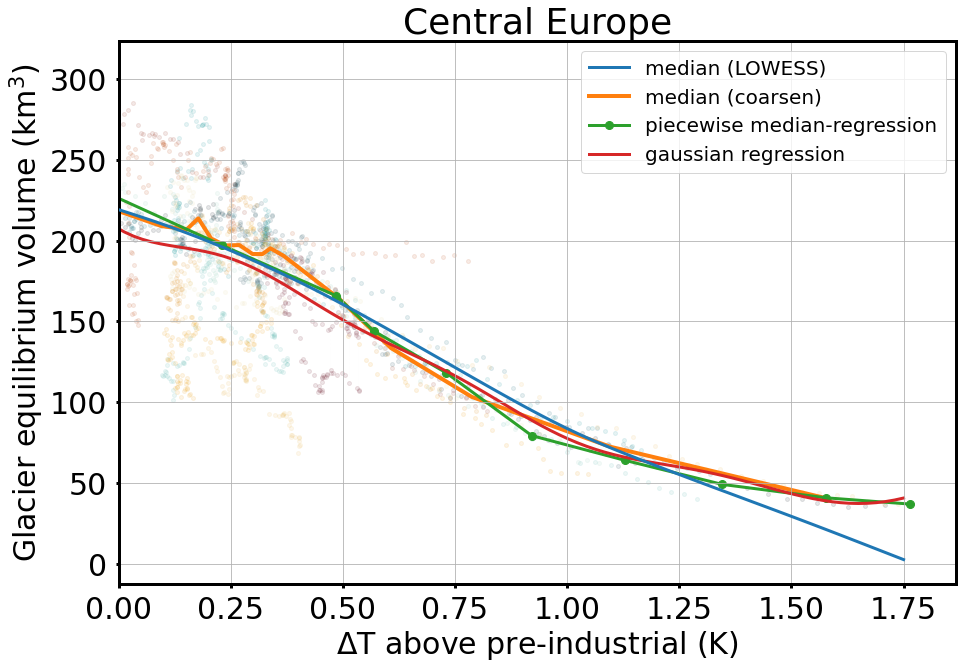

In [25]:
ax = plt.gca()
ax.set_prop_cycle(plot_gcm.create_color_cycler(lw=3,n=13))

# draw points 
ax.set_prop_cycle(plot_gcm.create_color_cycler(lw=3,n=13))
p_df = gcm_ds.equilibrium.to_pandas().T
p_df.plot(lw=0.01, marker='o',ax=ax,markersize=4,legend=True,zorder=1,alpha=0.1, label='_hidden')

# LOWESS regression
p1 = ax.plot(df_quantiles.index, df_quantiles[0.5], color='C0', linestyle='-',lw=3,zorder=5, label='median (LOWESS)')

# median over all gcms
p2 = gcm_ds.equilibrium.coarsen(GMT=100, boundary='pad').median().median(dim='gcm').plot(c='C1',linestyle='-',zorder=1,markersize=8,label='median (coarsen)',add_legend=True,ax=ax)

#piecewise regression
ax.plot(median_x, median_y,c='C2',linestyle='-',markersize=8,marker='o', zorder=1,label='piecewise median-regression')

# gaussian regression
ax.plot(np.linspace(-0.25,1.75,100).reshape(-1,1),mu_s, zorder=1,color='C3', label='gaussian regression')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[13:], labels[13:])

ax.set_ylabel(r'Glacier equilibrium volume (km$^3$)');
ax.set_xlabel(r'$\Delta$T above pre-industrial (K)');
ax.grid()
ax.set_title('Central Europe')
ax.set_xlim(0,None);
#plt.savefig(os.path.join('out/run_CMIP6_geod/plots/regional/Alps','equilibrium_GMT_xlim.png'),dpi=300)


## Get results from fair model 

In [26]:
co2_gmt = pd.read_csv('T_diff_CO2.csv').set_index('Year')
co2_gmt.sum(axis=1)

Year
1850    0.000017
1851    0.000073
1852    0.000158
1853    0.000257
1854    0.000367
          ...   
2016    0.691261
2017    0.706073
2018    0.720968
2019    0.735997
2020    0.748890
Length: 171, dtype: float64